## Generate synthetic Anomalies

trying to replicate the synthethic anomalies from the LOE paper

https://arxiv.org/abs/2202.08088
"""
Since the MVTEC training set contains
no anomalies, we contaminate it with artificial anomalies
that we create by adding zero-mean Gaussian noise to the
features of test set anomalies. We use a large variance for
the additive noise (equal to the empirical variance of the
anomalous features) to reduce information leakage from the
test set into the training set.
"""


$$X = \text{Wideresnet or other embeddings},A = \text{Real Anomalies}, S = \text{Synthethic Anomalies}$$
Assumed A is multivariate Gauss (which they are most probably not):
$$\mathbf{A} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}_{A})$$
They assume noise $\mathbf{\epsilon}$ to be added to the anomalies of the testset which increases the variance of S:
$$\mathbf{\epsilon} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma_{A}})$$
Therefore:
$$\mathbf{S} \sim \mathcal{N}(\boldsymbol{\mu},  \boldsymbol{\Sigma_{A}} + \boldsymbol{\Sigma_{A}})$$

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
import seaborn as sns


from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.model_selection import train_test_split
import torch.nn as nn

# FILEPATH: /home/bule/projects/MVTec_Visualizer/workspace/mvtec_syntheticAnomalies.ipynb
import sys
sys.path.append('..')
from utils.helpers import *
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
# set the embeddings & read it 
FILENAME =  'MVTEC_WIDERESNET50_3thBlock_embeddings_df'#'MVTEC_CLIP_embeddings_df'#'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [3]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']}


# change class here
category='metal_nut'
#number of synthetic anomalies to create
n_synthetic=30

synthetic_sampling_method='additive_0_mean_gauss' #  or multivariate_gauss
#synthetic_sampling_method='multivariate_gauss' #  or multivariate_gauss

# create synthetic anomalies
combined_samples,labels,class_list= create_synset_for_class(category,df,n_synthetic, sampler=synthetic_sampling_method)

info={'filename':FILENAME,'category':category,'n_synthetic':n_synthetic,'sampler':synthetic_sampling_method}

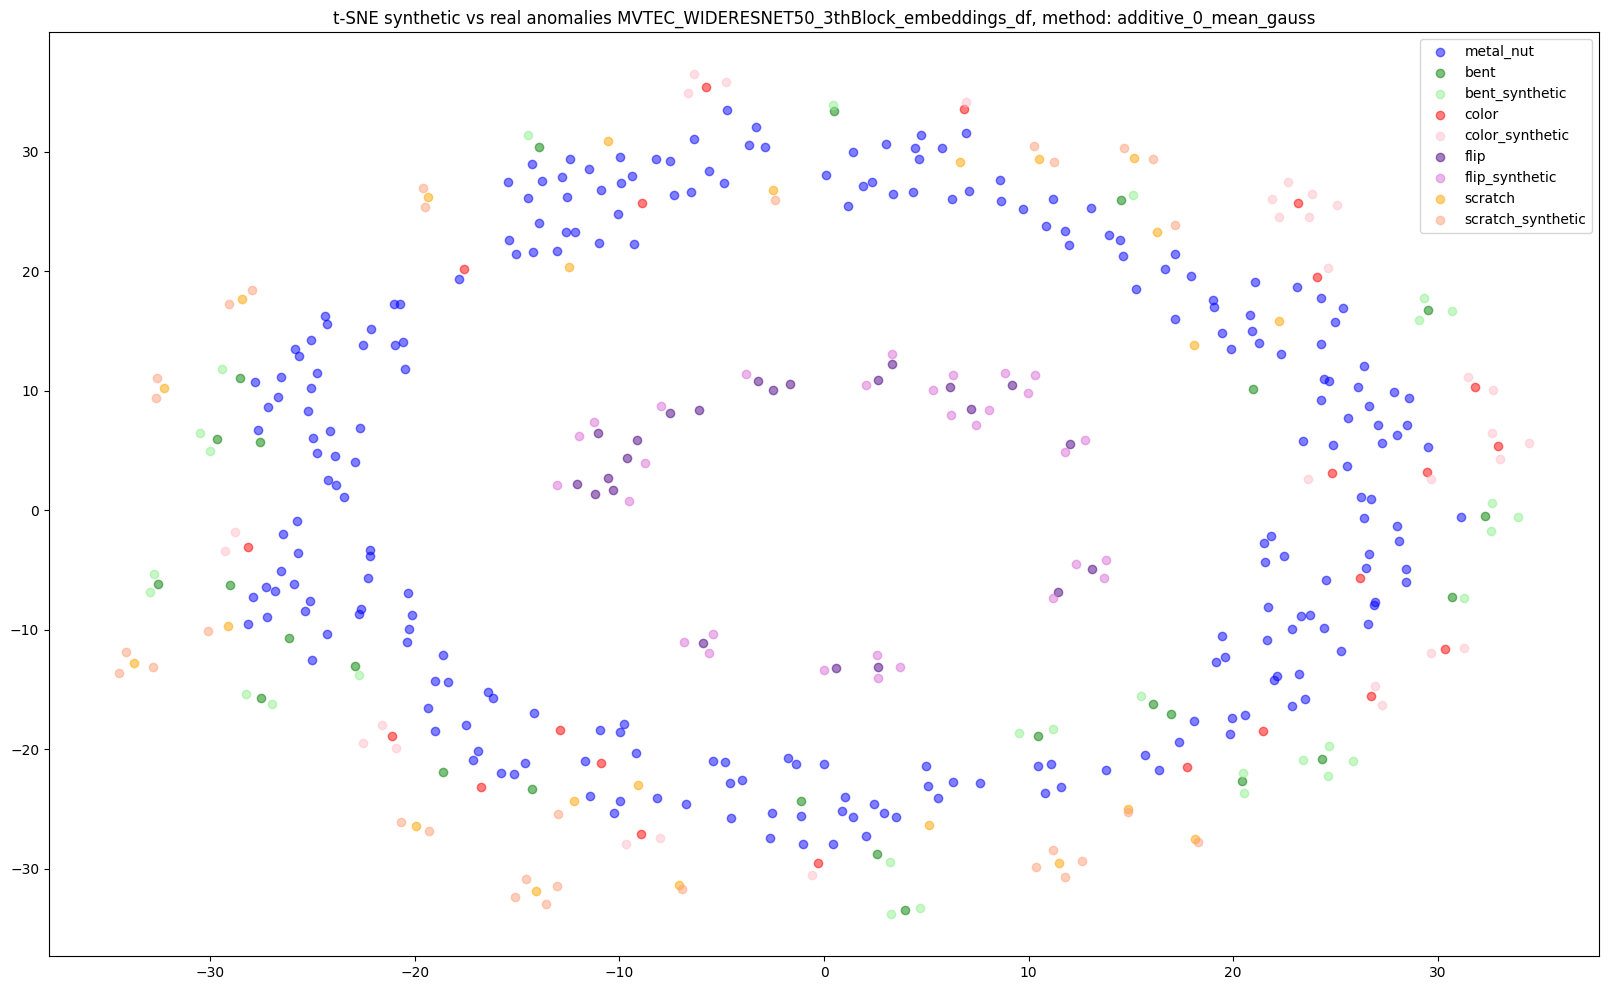

In [4]:
for _ in range(1):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    reduced_data = tsne.fit_transform(combined_samples)
    colors = ['blue', 'green', 'lightgreen', 'red', 'pink', 'indigo', 'orchid', 'orange', 'lightsalmon', 'purple', 'lavender', 'saddlebrown', 'wheat', 'black', 'gray','olive', 'palegreen']
    jitter_amount = 0.3
    # Plotting
    plt.figure(figsize=(20, 12))
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])
        
    plt.title(f"t-SNE synthetic vs real anomalies {FILENAME}, method: {info['sampler']}")
    plt.legend()
    plt.show()

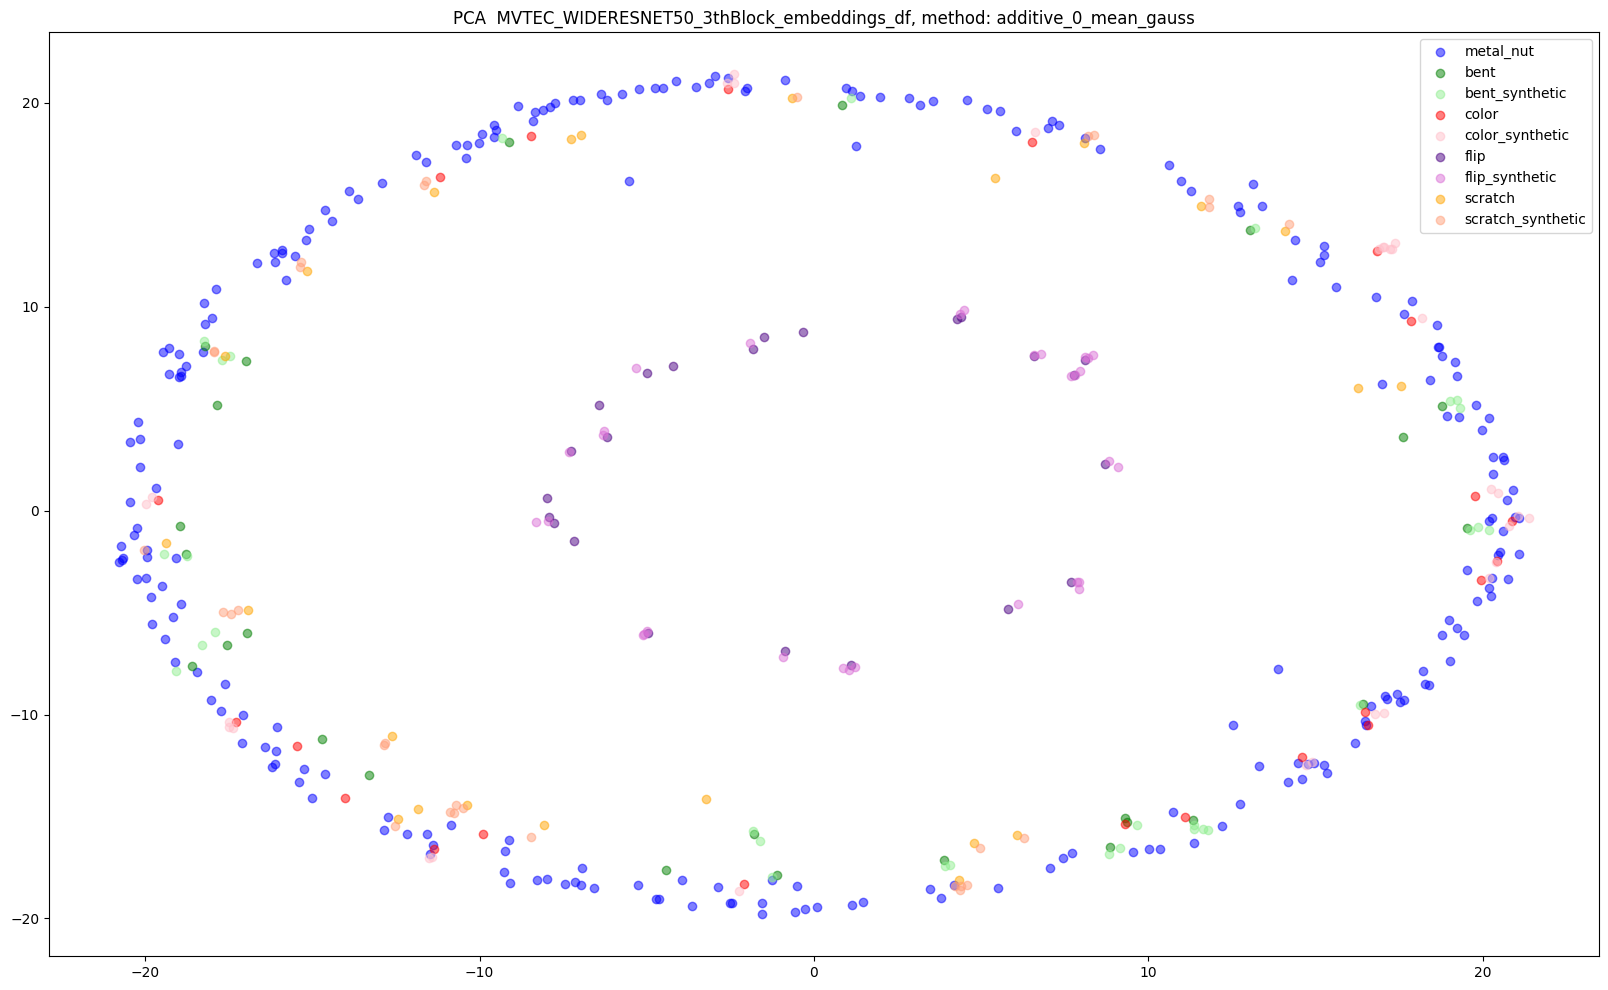

In [5]:
# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_samples)

# Plotting
plt.figure(figsize=(20, 12))
# Iterate over each unique label to plot them separately
for i in range(len(class_list)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])

plt.title(f"PCA  {FILENAME}, method: {info['sampler']}")
plt.legend()
plt.show()


# Model based Reconstruction

- learning normal state and detect deviation

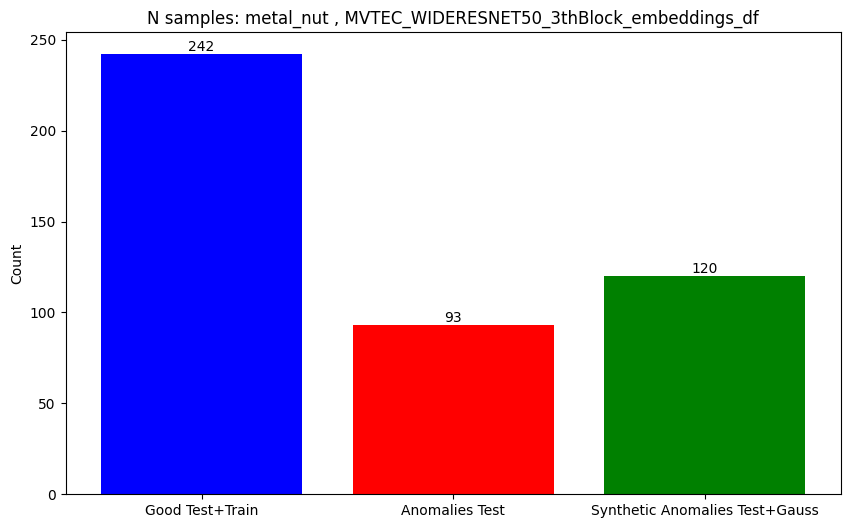

In [6]:
# filter for the synthetic and real anomalies
normals=combined_samples[labels==0]
anomalies=combined_samples[(labels % 2 != 0) & (labels != 0)] 
synthetic_anomalies=combined_samples[(labels % 2 == 0) & (labels != 0)] 
# plot it
plot_data_distribution(normals, anomalies, synthetic_anomalies,info=info)

## PCA

### "train" on normal data

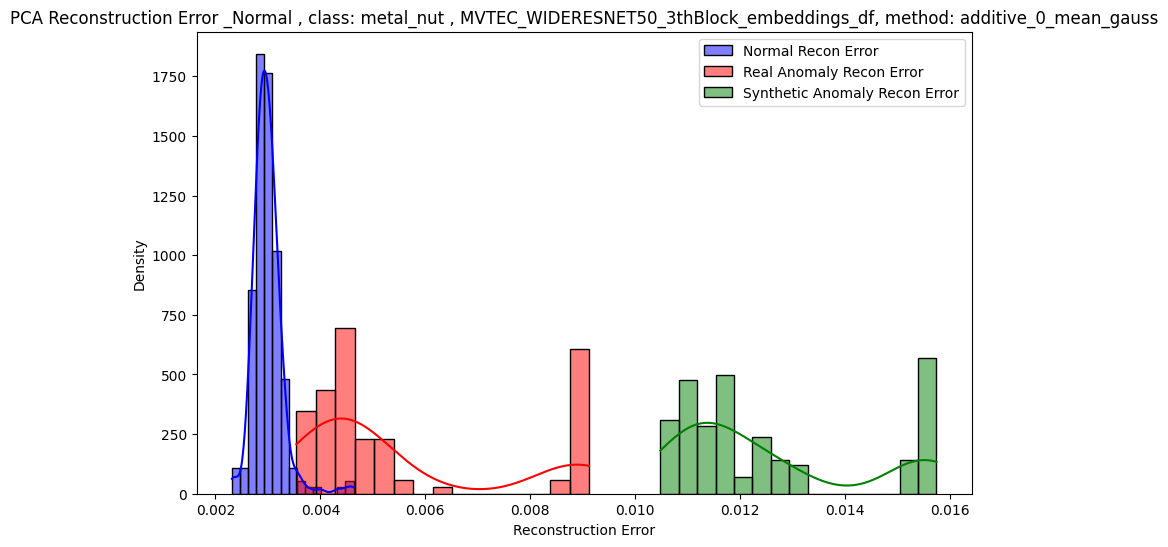

In [14]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)

pca = PCA(n_components=20)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons

# Normal data
reduced_normal_data = pca.fit_transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
#Real Anomalies 
reduced_anomaly_data = pca.transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))

#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))

plt.figure(figsize=(10, 6))
bins_number = 15

# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _Normal , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

### "train" on anomalous data

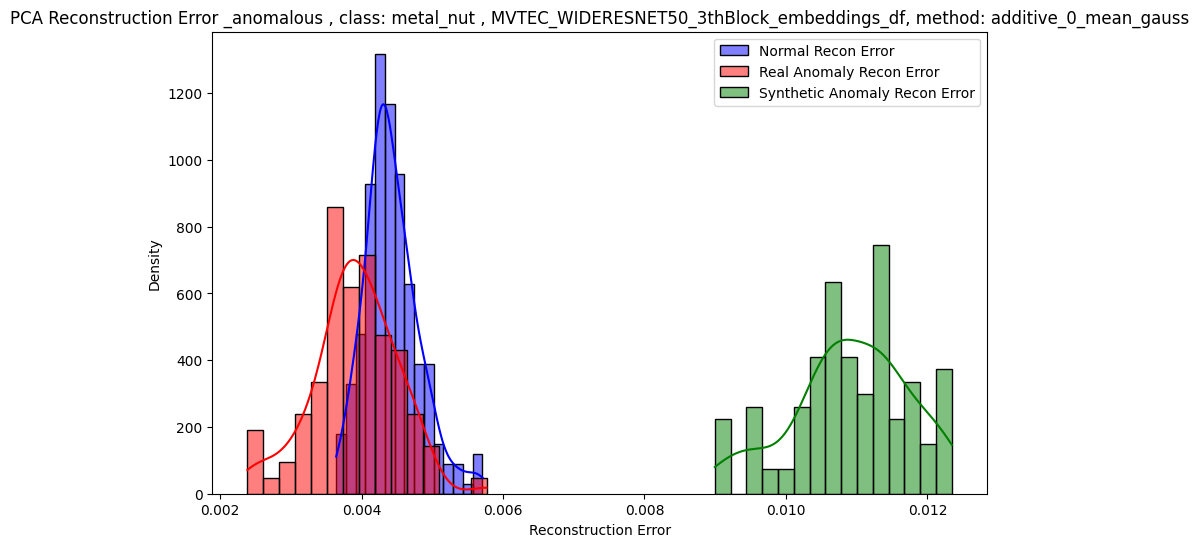

In [8]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)
pca = PCA(n_components=10)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons

#Real Anomalies 
reduced_anomaly_data = pca.fit_transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))
    
# Normal data
reduced_normal_data = pca.transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))

plt.figure(figsize=(10, 6))
bins_number = 15

# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _anomalous , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

### "train" on synthethic anomalous data

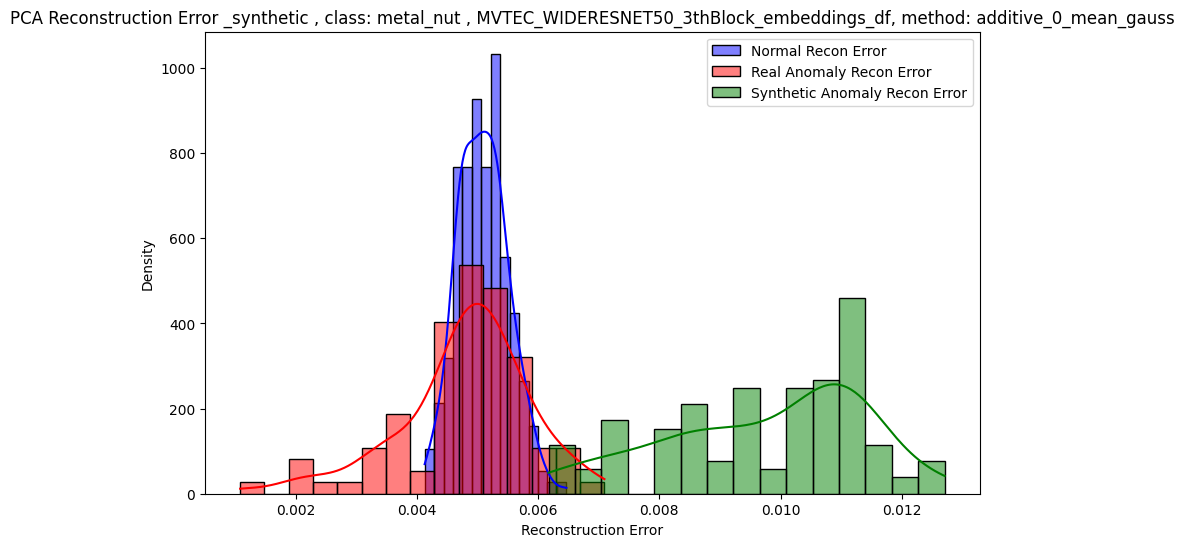

In [9]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)
pca = PCA(n_components=10)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons


#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.fit_transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))
    
#Real Anomalies 
reduced_anomaly_data = pca.transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))
    
# Normal data
reduced_normal_data = pca.transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
plt.figure(figsize=(10, 6))
bins_number = 15

# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _synthetic , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

## Autoencoder

- train autencoder to see wheter synthetic anomalies are valid or not

### train on normal data

Epoch [1/30], Train Loss: 145.7781, Validation Loss: 0.0786
Epoch [2/30], Train Loss: 0.0309, Validation Loss: 0.0250
Epoch [3/30], Train Loss: 0.0248, Validation Loss: 0.0243
Epoch [4/30], Train Loss: 0.0238, Validation Loss: 0.0231
Epoch [5/30], Train Loss: 0.0226, Validation Loss: 0.0219
Epoch [6/30], Train Loss: 0.0213, Validation Loss: 0.0206
Epoch [7/30], Train Loss: 0.0201, Validation Loss: 0.0194
Epoch [8/30], Train Loss: 0.0189, Validation Loss: 0.0183
Epoch [9/30], Train Loss: 0.0178, Validation Loss: 0.0172
Epoch [10/30], Train Loss: 0.0167, Validation Loss: 0.0162
Epoch [11/30], Train Loss: 0.0158, Validation Loss: 0.0153
Epoch [12/30], Train Loss: 0.0149, Validation Loss: 0.0144
Epoch [13/30], Train Loss: 0.0140, Validation Loss: 0.0136
Epoch [14/30], Train Loss: 0.0133, Validation Loss: 0.0129
Epoch [15/30], Train Loss: 0.0126, Validation Loss: 0.0123
Epoch [16/30], Train Loss: 0.0120, Validation Loss: 0.0117
Epoch [17/30], Train Loss: 0.0115, Validation Loss: 0.0112
Epoc

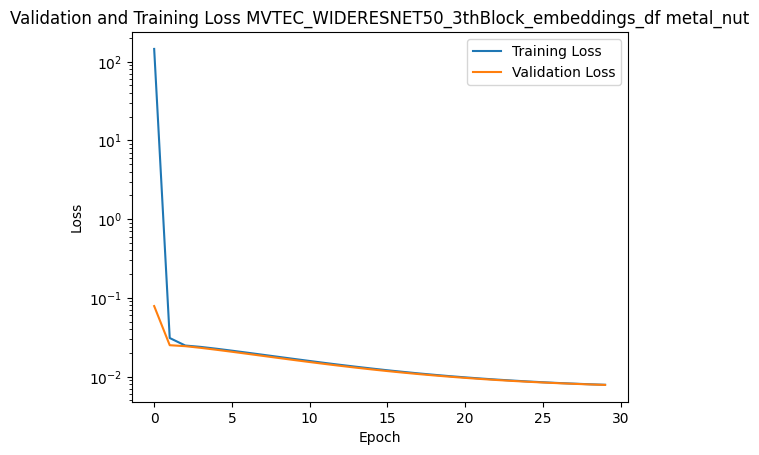

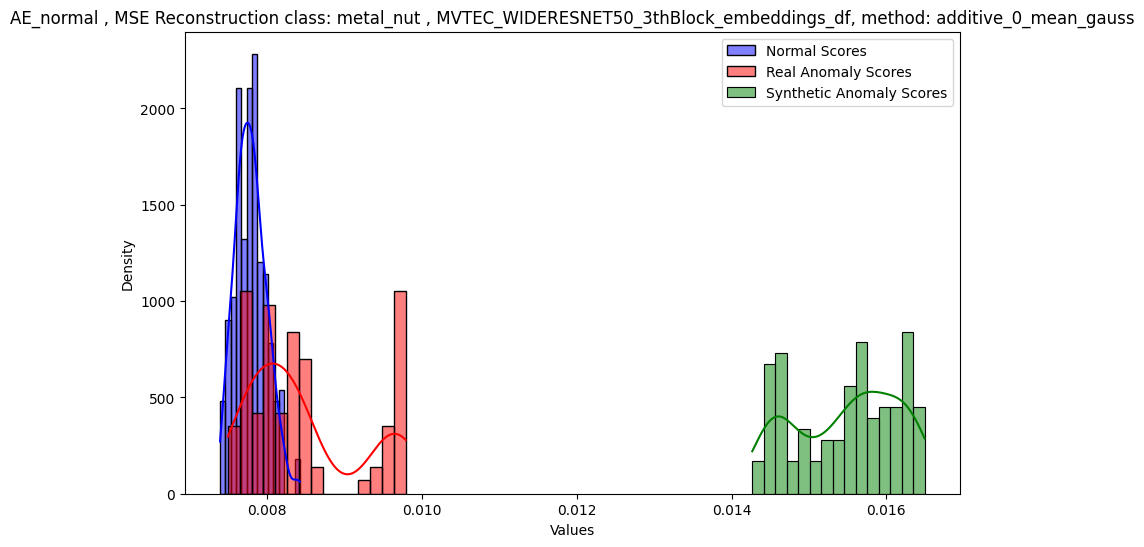

In [10]:
normal_data = torch.tensor(normals)
autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)

normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}, method: {info["sampler"]}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

Epoch [1/30], Train Loss: 120.1453, Validation Loss: 0.0222
Epoch [2/30], Train Loss: 0.1840, Validation Loss: 0.0226
Epoch [3/30], Train Loss: 0.0222, Validation Loss: 0.0217
Epoch [4/30], Train Loss: 0.0212, Validation Loss: 0.0206
Epoch [5/30], Train Loss: 0.0201, Validation Loss: 0.0195
Epoch [6/30], Train Loss: 0.0190, Validation Loss: 0.0184
Epoch [7/30], Train Loss: 0.0179, Validation Loss: 0.0173
Epoch [8/30], Train Loss: 0.0169, Validation Loss: 0.0164
Epoch [9/30], Train Loss: 0.0160, Validation Loss: 0.0155
Epoch [10/30], Train Loss: 0.0151, Validation Loss: 0.0146
Epoch [11/30], Train Loss: 0.0143, Validation Loss: 0.0139
Epoch [12/30], Train Loss: 0.0136, Validation Loss: 0.0132
Epoch [13/30], Train Loss: 0.0129, Validation Loss: 0.0126
Epoch [14/30], Train Loss: 0.0123, Validation Loss: 0.0120
Epoch [15/30], Train Loss: 0.0117, Validation Loss: 0.0114
Epoch [16/30], Train Loss: 0.0112, Validation Loss: 0.0110
Epoch [17/30], Train Loss: 0.0108, Validation Loss: 0.0105
Epoc

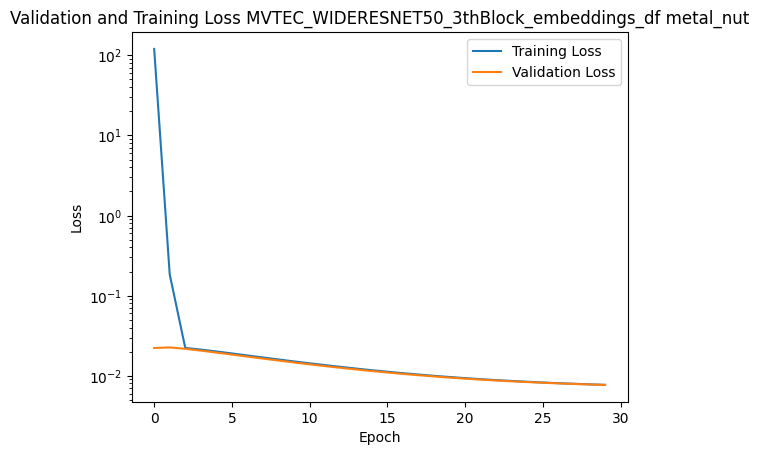

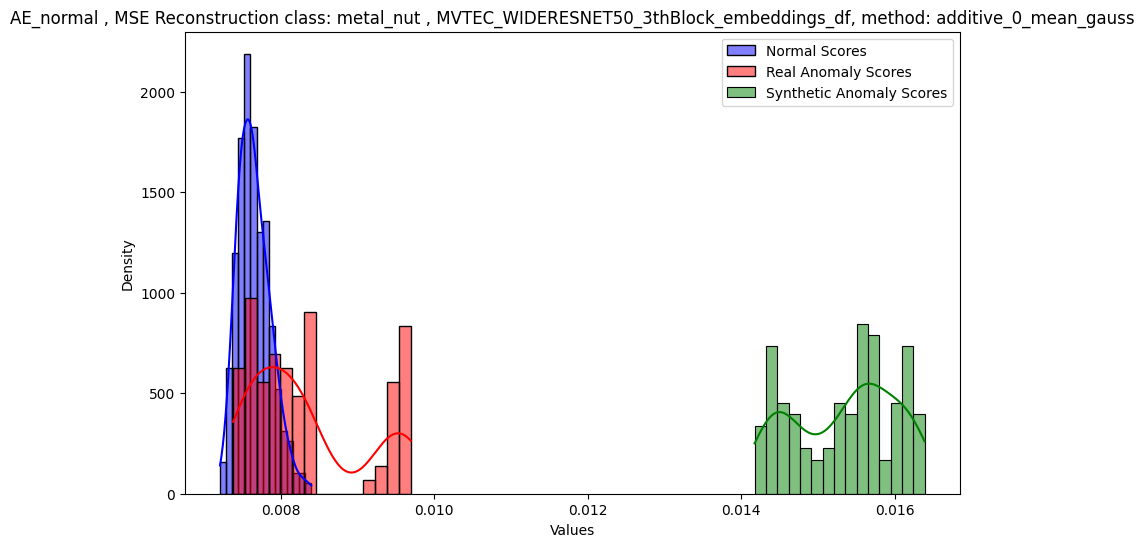

In [11]:
torch.cuda.empty_cache()
normal_data = torch.tensor(normals)

autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)
normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}, method: {info["sampler"]}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on synthetic data

Epoch [1/30], Train Loss: 362.7044, Validation Loss: 0.0273
Epoch [2/30], Train Loss: 0.5276, Validation Loss: 0.0291
Epoch [3/30], Train Loss: 0.0296, Validation Loss: 0.0296
Epoch [4/30], Train Loss: 0.0296, Validation Loss: 0.0295
Epoch [5/30], Train Loss: 0.0294, Validation Loss: 0.0292
Epoch [6/30], Train Loss: 0.0318, Validation Loss: 0.0288
Early stopping triggered!


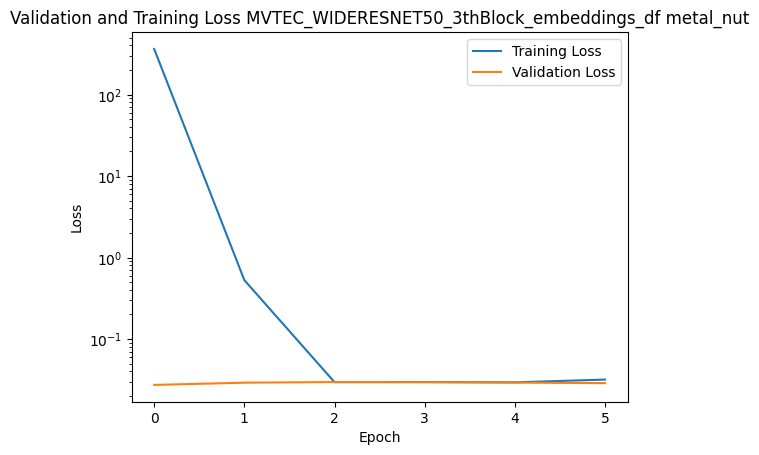

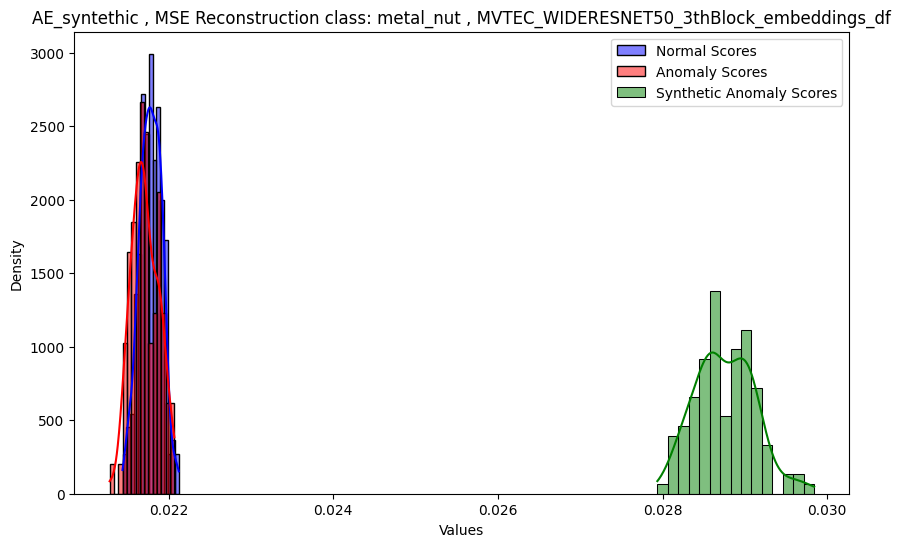

In [12]:
torch.cuda.empty_cache()
synthethicdata = torch.tensor(synthetic_anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(synthethicdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_syntethic , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on anomalies

In [13]:
torch.cuda.empty_cache()
anomaliesdata = torch.tensor(anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(anomaliesdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_anomalies , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 766.00 MiB. GPU 0 has a total capacty of 23.64 GiB of which 677.31 MiB is free. Including non-PyTorch memory, this process has 22.97 GiB memory in use. Of the allocated memory 21.86 GiB is allocated by PyTorch, and 678.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF